In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
stock = yf.Ticker("WIPRO.NS")
d = stock.history(interval="1d", period="15y")
d.drop(['Dividends','Stock Splits'], axis=1, inplace=True)
d.to_csv('Stock_data')
df = pd.read_csv('Stock_data')
StockData = df.sort_values('Date')
print("Number of rows and columns:", StockData.shape)
StockData.head()


Number of rows and columns: (3698, 6)


,Date,Open,High,Low,Close,Volume
0,2007-04-27,109.618544,109.820830,107.181504,108.992424,4136626
1,2007-04-30,108.847924,110.716642,108.077317,110.119415,2654462
2,2007-05-03,111.159757,112.691327,109.136916,109.984573,5526470
3,2007-05-04,122.333526,122.333526,108.077341,109.291046,3890715
4,2007-05-07,110.196491,110.196491,106.198975,106.459053,2729968


In [4]:
StockData
type(StockData)
StockData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3698 entries, 0 to 3697
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3698 non-null   object 
 1   Open    3698 non-null   float64
 2   High    3698 non-null   float64
 3   Low     3698 non-null   float64
 4   Close   3698 non-null   float64
 5   Volume  3698 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 187.8+ KB


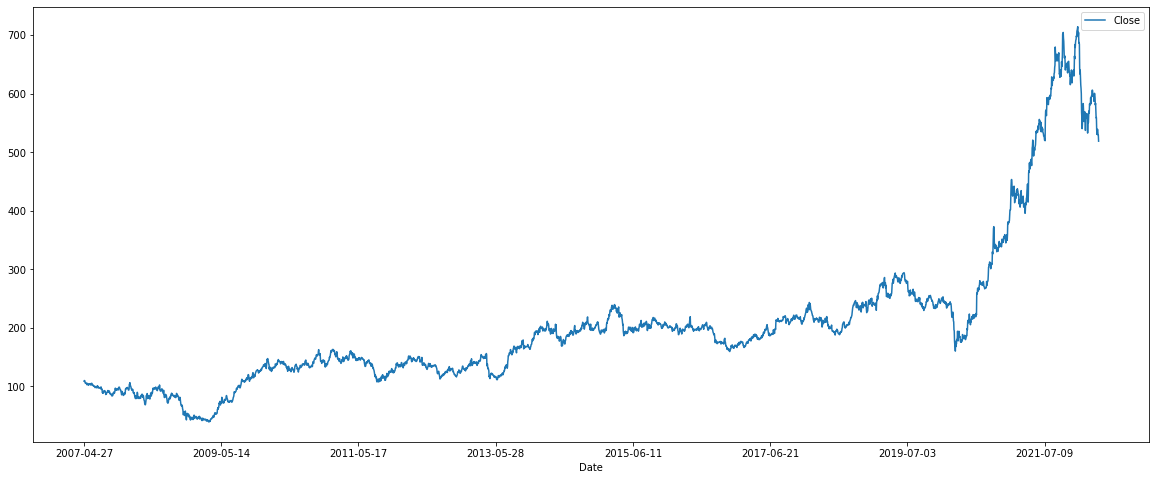

In [10]:
# Creating a column as date
#StockData['TradeDate']=StockData.index
 
# Plotting the stock prices
%matplotlib inline
StockData.plot(x='Date', y='Close', kind='line', figsize=(20,8))

In [3]:
# Extracting the closing prices of each day
FullData=StockData[['Close']].values
print(FullData[0:5])
 
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
  
# Choosing between Standardization or normalization

#sc = StandardScaler()
sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Normalization ###')
X[0:5]

[[90.46112061]
 [95.28466797]
 [95.60302734]
 [99.63552094]
 [96.97293091]]
### After Normalization ###


array([[0.09733726],
       [0.10657877],
       [0.10718872],
       [0.11491464],
       [0.10981334]])

In [4]:
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(3681, 10, 1)

#### Output Data shape ####
(3681, 1)


In [5]:
# Choosing the number of testing data records
TestingRecords=10
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(3671, 10, 1)
(3671, 1)

#### Testing Data shape ####
(10, 10, 1)
(10, 1)


In [6]:
#Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

[[0.09733726]
 [0.10657877]
 [0.10718872]
 [0.11491464]
 [0.10981334]
 [0.10482289]
 [0.10097839]
 [0.10339966]
 [0.09345577]
 [0.09774387]] -- [0.08999941]
[[0.10657877]
 [0.10718872]
 [0.11491464]
 [0.10981334]
 [0.10482289]
 [0.10097839]
 [0.10339966]
 [0.09345577]
 [0.09774387]
 [0.08999941]] -- [0.0973742]


In [7]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)


Number of TimeSteps: 10
Number of Features: 1


In [8]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
regressor.add(Dense(units = 1))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
##################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 125)
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/125
735/735 [==============================] - 11s 11ms/step - loss: 0.0168
Epoch 2/125
735/735 [==============================] - 6s 9ms/step - loss: 3.9290e-04
Epoch 3/125
735/735 [==============================] - 6s 9ms/step - loss: 4.3174e-04
Epoch 4/125
735/735 [==============================] - 6s 8ms/step - loss: 3.2359e-04
Epoch 5/125
735/735 [==============================] - 6s 8ms/step - loss: 3.0186e-04
Epoch 6/125
735/735 [==============================] - 7s 9ms/step - loss: 2.9386e-04
Epoch 7/125
735/735 [==============================] - 7s 9ms/step - loss: 3.0793e-04
Epoch 8/125
735/735 [==============================] - 7s 10ms/step - loss: 2.9012e-04
Epoch 9/125
735/735 [==============================] - 7s 9ms/step - loss: 2.8904e-04
Epoch 10/125
735/735 [==============================] - 6s 9ms/step - loss: 2.8391e-04
Epoch 11/125
735/735 [==============================] - 6s 8ms/step - loss: 2.6979e-04
Epoch 12/125
735/735 [==============================]

Accuracy: 98.77660527966425


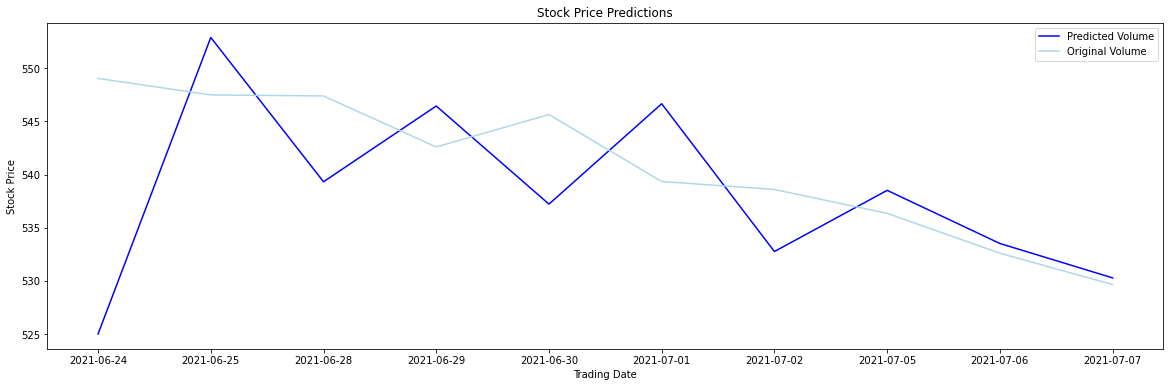

In [9]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
 
# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())
 
# Visualising the results
import matplotlib.pyplot as plt
 
plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['Date'])
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

In [10]:
from tensorflow.keras.models import load_model

regressor.save('my_model.h5')

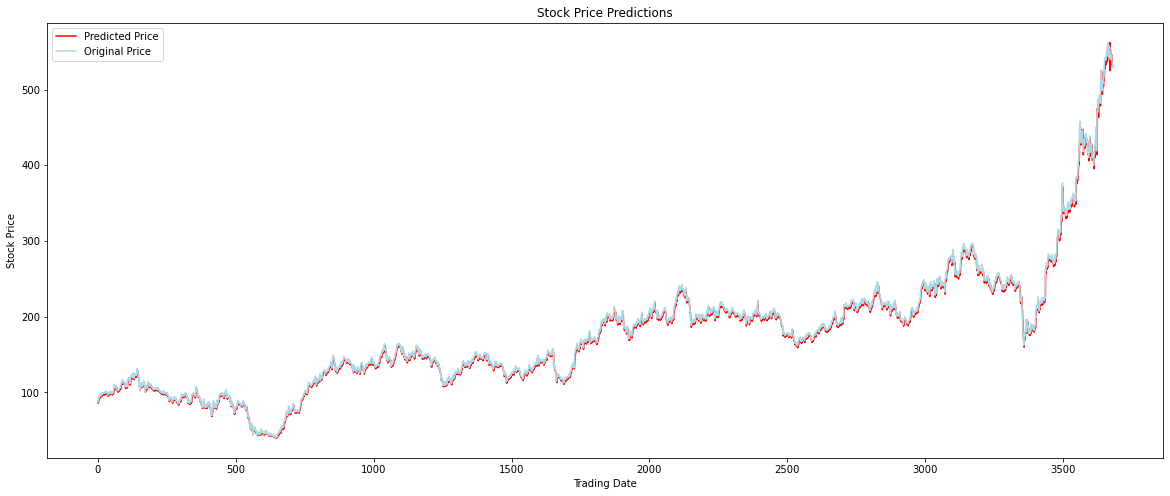

In [11]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]
 
# plotting the full data
plt.plot(FullDataPredictions, color = 'red', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')
 
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

validation=pd.DataFrame(FullDataOrig,columns=['Original'])
validation['Prediction']=FullDataPredictions
#validation.to_csv('BLK.csv')
#from google.colab import files
#files.download('BLK.csv') 


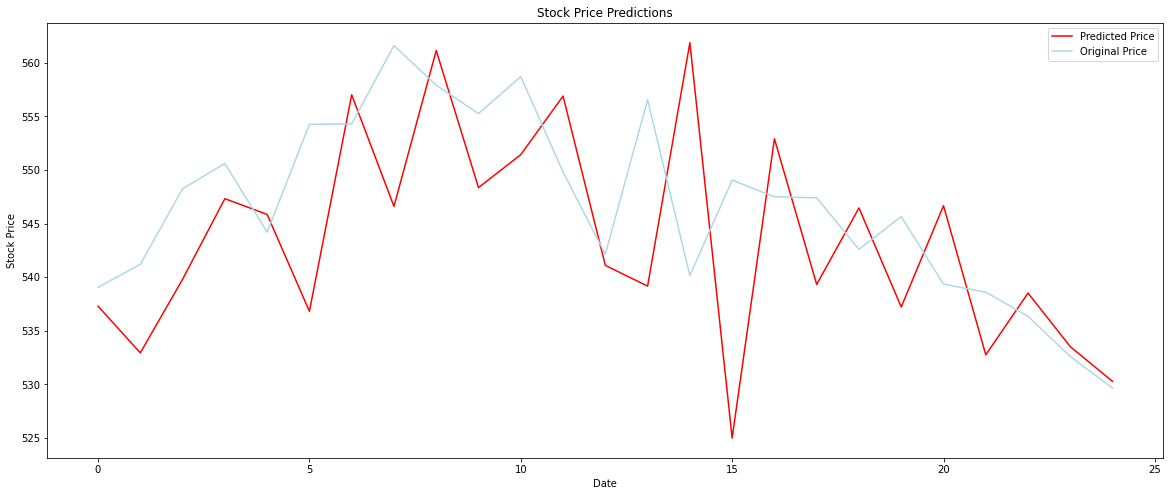

In [12]:
validation['Absolute']=abs(validation['Prediction']-validation['Original'])
#validation.mean()

new_dt = validation.filter(['Prediction'])
last1000Dayspred = new_dt[-25:].values

new_dt1 = validation.filter(['Original'])
last1000Daysorig = new_dt1[-25:].values

plt.plot(last1000Dayspred, color = 'red', label = 'Predicted Price')
plt.plot(last1000Daysorig , color = 'lightblue', label = 'Original Price')
 
 
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()
#validation.to_csv('BLKData.csv')
#from google.colab import files
#files.download('BLKData.csv') 


In [13]:
#validation.tail()
validation.mean()

Original      177.901841
Prediction    175.279785
Absolute        3.298088
dtype: float64

In [14]:
1# Last 10 days prices
dt = stock.history(interval="1d", period="10d")
new_dt = dt.filter(['Close'])

last10Days = new_dt[-10:].values

##Creating an empty test list
Last10Days = []

##Append the past 60 days
Last10Days.append(last10Days)

##Converting the X_test_data into a numpy array
Last10Days = np.array(Last10Days)
 
# Normalizing the data just like we did for training the model
Last10Days=DataScaler.transform(Last10Days.reshape(-1,1))
 
# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)
 
#############################
 
# Making predictions on data
predicted_Price = regressor.predict(Last10Days)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price

array([[529.32025]], dtype=float32)

In [15]:
present=stock.history(interval="1d", period="10d")
present

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-06-24,541.900024,550.549988,539.200012,549.049988,8668680,0,0
2021-06-25,549.849976,551.000000,540.500000,547.500000,5039822,0,0
2021-06-28,549.750000,550.799988,544.250000,547.400024,3259830,0,0
2021-06-29,547.799988,553.750000,541.000000,542.599976,7927880,0,0
2021-06-30,544.849976,548.000000,542.000000,545.650024,4293322,0,0
2021-07-01,545.000000,545.900024,538.000000,539.349976,4329374,0,0
2021-07-02,540.099976,542.299988,533.599976,538.599976,4157307,0,0
2021-07-05,542.900024,542.900024,535.549988,536.349976,3439169,0,0
2021-07-06,536.549988,538.299988,531.849976,532.599976,4193441,0,0


In [16]:
# Considering the Full Data again which we extracted above
# Printing the last 10 values
print('Original Prices')
print(FullData[-10:])
 
print('###################')
 
# Printing last 10 values of the scaled data which we have created above for the last model
# Here I am changing the shape of the data to one dimensional array because
# for Multi step data preparation we need to X input in this fashion
X=X.reshape(X.shape[0],)
print('Scaled Prices')
print(X[-10:])

Original Prices
[[549.04998779]
 [547.5       ]
 [547.40002441]
 [542.59997559]
 [545.65002441]
 [539.34997559]
 [538.59997559]
 [536.34997559]
 [532.59997559]
 [529.65002441]]
###################
Scaled Prices
[0.97595527 0.97298562 0.97279408 0.96359759 0.96944122 0.95737086
 0.95593392 0.95162311 0.94443842 0.93878656]


In [17]:
# Multi step data preparation
 
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps=5 # How many days in future you want to predict the prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
 
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data.shape)

### Input Data Shape ###
(3676, 10, 1)
### Output Data Shape ###
(3676, 5)


In [18]:
# Choosing the number of testing data records
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
 
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)



#### Training Data shape ####
(3671, 10, 1)
(3671, 5)

#### Testing Data shape ####
(5, 10, 1)
(5, 5)


In [19]:
# Visualizing the input and output being sent to the LSTM model
# Based on last 10 days prices we are learning the next 5 days of prices
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp)
    print('====>')
    print(out)
    print('#'*20)


[[0.09733726]
 [0.10657877]
 [0.10718872]
 [0.11491464]
 [0.10981334]
 [0.10482289]
 [0.10097839]
 [0.10339966]
 [0.09345577]
 [0.09774387]]
====>
[0.08999941 0.0973742  0.09768841 0.10010972 0.10654183]
####################
[[0.10657877]
 [0.10718872]
 [0.11491464]
 [0.10981334]
 [0.10482289]
 [0.10097839]
 [0.10339966]
 [0.09345577]
 [0.09774387]
 [0.08999941]]
====>
[0.0973742  0.09768841 0.10010972 0.10654183 0.10260493]
####################


In [20]:

# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [21]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
 
# Adding the Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predict
regressor.add(Dense(units = FutureTimeSteps))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
###################################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/100
735/735 [==============================] - 12s 11ms/step - loss: 0.0257
Epoch 2/100
735/735 [==============================] - 7s 10ms/step - loss: 7.8799e-04
Epoch 3/100
735/735 [==============================] - 7s 9ms/step - loss: 4.4057e-04
Epoch 4/100
735/735 [==============================] - 6s 9ms/step - loss: 3.5806e-04
Epoch 5/100
735/735 [==============================] - 7s 9ms/step - loss: 3.2495e-04
Epoch 6/100
735/735 [==============================] - 6s 9ms/step - loss: 3.3236e-04
Epoch 7/100
735/735 [==============================] - 6s 8ms/step - loss: 3.5449e-04
Epoch 8/100
735/735 [==============================] - 6s 8ms/step - loss: 3.2644e-04
Epoch 9/100
735/735 [==============================] - 6s 8ms/step - loss: 3.2027e-04
Epoch 10/100
735/735 [==============================] - 6s 8ms/step - loss: 3.7484e-04
Epoch 11/100
735/735 [==============================] - 6s 8ms/step - loss: 2.8666e-04
Epoch 12/100
735/735 [==============================]

In [22]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
print('#### Predicted Prices ####')
print(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
print('\n#### Original Prices ####')
print(orig)

#### Predicted Prices ####
[[529.63837 528.748   529.9577  532.88763 532.0574 ]
 [554.109   554.5958  555.41583 553.8026  557.5326 ]
 [544.70856 544.41284 545.4654  546.4238  547.58405]
 [545.9053  545.7227  546.7413  547.32806 548.8592 ]
 [539.1787  538.7957  539.86316 541.1183  541.97046]]

#### Original Prices ####
[[549.04998779 547.5        547.40002441 542.59997559 545.65002441]
 [547.5        547.40002441 542.59997559 545.65002441 539.34997559]
 [547.40002441 542.59997559 545.65002441 539.34997559 538.59997559]
 [542.59997559 545.65002441 539.34997559 538.59997559 536.34997559]
 [545.65002441 539.34997559 538.59997559 536.34997559 532.59997559]]


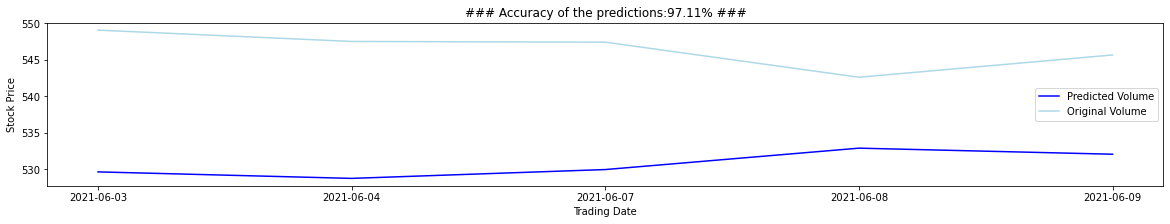

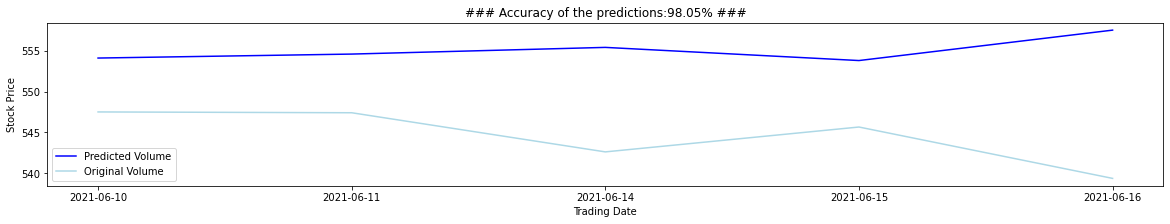

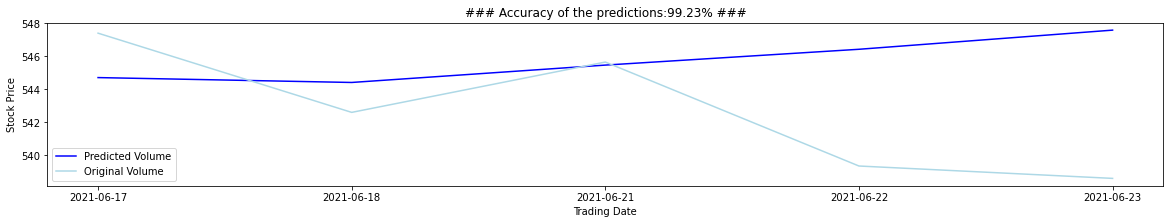

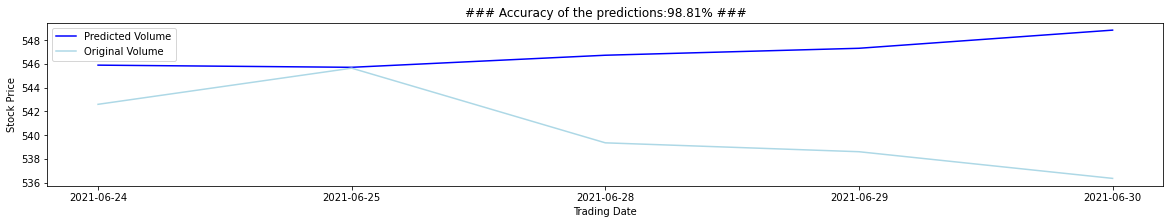

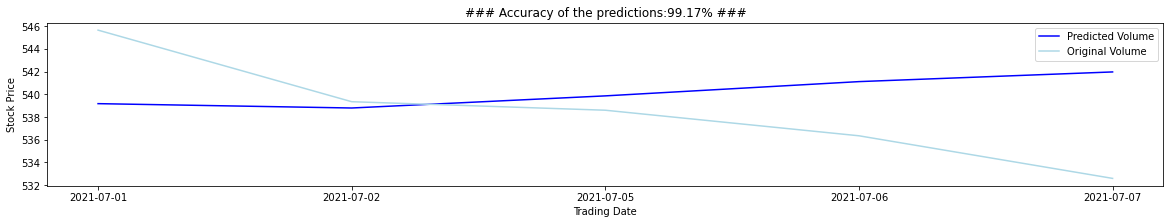

In [23]:
import matplotlib.pyplot as plt
 
for i in range(len(orig)):
    Prediction=predicted_Price[i]
    Original=orig[i]
    
    # Visualising the results
    plt.plot(Prediction, color = 'blue', label = 'Predicted Volume')
    plt.plot(Original, color = 'lightblue', label = 'Original Volume')
 
    plt.title('### Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ###')
    plt.xlabel('Trading Date')
    
    startDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1)
    endDateIndex=(FutureTimeSteps*TestingRecords)-FutureTimeSteps*(i+1) + FutureTimeSteps
    TotalRows=StockData.shape[0]
 
    plt.xticks(range(FutureTimeSteps), StockData.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['Date'])
    plt.ylabel('Stock Price')
 
    plt.legend()
    fig=plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    plt.show()

In [24]:
dt = stock.history(interval="1d", period="10d")
new_dt = dt.filter(['Close'])

Last10DaysPrices = new_dt[-10:].values
 
# Reshaping the data to (-1,1 )because its a single entry
Last10DaysPrices=Last10DaysPrices.reshape(-1, 1)
 
# Scaling the data on the same level on which model was trained
X_test=DataScaler.transform(Last10DaysPrices)
 
NumberofSamples=1
TimeSteps=X_test.shape[0]
NumberofFeatures=X_test.shape[1]
# Reshaping the data as 3D input
X_test=X_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
 
# Generating the predictions for next 5 days
Next5DaysPrice = regressor.predict(X_test)
 
# Generating the prices in original scale
Next5DaysPrice = DataScaler.inverse_transform(Next5DaysPrice)
Next5DaysPrice

array([[534.0234, 533.8911, 534.8638, 535.3132, 536.9496]], dtype=float32)

In [25]:
model = load_model('my_model.h5')